In [3]:
# imports
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns

from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from keras.applications import ConvNeXtTiny

In [4]:
# set the training and testing paths
train_dir = '../Images/Training'
test_dir = '../Images/Testing'

In [5]:
# manually list out the class names
class_names = ['glioma', 'meningioma', 'notumor', 'pituitary']

In [6]:
datagen = ImageDataGenerator(validation_split=0.30)
# Get the training data
train_ds = datagen.flow_from_directory(
    train_dir,
    target_size=(256, 256),
    color_mode='grayscale',
    batch_size=32,
    classes=class_names,
    class_mode='categorical',
    subset='training',  # Set as training data
    seed=42
)

# Get the validation data
val_ds = datagen.flow_from_directory(
    train_dir,
    target_size=(256, 256),
    color_mode='grayscale',
    batch_size=32,
    classes=class_names,
    class_mode='categorical',
    subset='validation',  # Set as validation data
    seed=42,
    shuffle=False
)

# Get the test data
test_ds = datagen.flow_from_directory(
    test_dir,
    target_size=(256, 256),
    color_mode='grayscale',
    class_mode='categorical',
    seed=42,
    shuffle=False
)


Found 4571 images belonging to 4 classes.
Found 1141 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


In [7]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 1)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(4, activation='softmax'))

In [10]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [13]:
early_stopping = EarlyStopping(patience=5)

In [14]:
history = model.fit(train_ds, validation_data=val_ds, epochs=10, callbacks=[early_stopping])

Epoch 1/10
143/143 [==============================] - 24s 165ms/step - loss: 0.0335 - accuracy: 0.9910 - val_loss: 1.2293 - val_accuracy: 0.7870
Epoch 2/10
143/143 [==============================] - 24s 166ms/step - loss: 0.0232 - accuracy: 0.9923 - val_loss: 1.3639 - val_accuracy: 0.7853
Epoch 3/10
143/143 [==============================] - 37s 262ms/step - loss: 0.0445 - accuracy: 0.9882 - val_loss: 1.1737 - val_accuracy: 0.7695
Epoch 4/10
143/143 [==============================] - 59s 408ms/step - loss: 0.0498 - accuracy: 0.9838 - val_loss: 1.7282 - val_accuracy: 0.7853
Epoch 5/10
143/143 [==============================] - 62s 428ms/step - loss: 0.0207 - accuracy: 0.9917 - val_loss: 1.5538 - val_accuracy: 0.7704
Epoch 6/10
143/143 [==============================] - 53s 366ms/step - loss: 0.0029 - accuracy: 0.9991 - val_loss: 2.1274 - val_accuracy: 0.7695
Epoch 7/10
143/143 [==============================] - 62s 438ms/step - loss: 6.1432e-04 - accuracy: 0.9998 - val_loss: 2.3128 - va

In [31]:
import sys
sys.path.append('../modules/')
import os
import model as m
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [25]:
def calculate_metrics(true_classes, predicted_classes):
    '''
    Calculate accuracy, precision, recall, and F1 score.
    '''
    accuracy = accuracy_score(true_classes, predicted_classes)
    precision = precision_score(true_classes, predicted_classes, average='weighted')
    recall = recall_score(true_classes, predicted_classes, average='weighted')
    f1 = f1_score(true_classes, predicted_classes, average='weighted')
    return accuracy, precision, recall, f1


In [20]:
# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(test_ds)

41/41 [==============================] - 4s 83ms/step - loss: 0.9005 - accuracy: 0.9054


In [21]:
# Get the predicted classes
y_pred = model.predict(test_ds)
predicted_classes = np.argmax(y_pred, axis=1)

41/41 [==============================] - 3s 72ms/step


In [22]:
# Get the true classes
true_classes = test_ds.classes

In [26]:
# Calculate metrics
accuracy, precision, recall, f1 = calculate_metrics(true_classes, predicted_classes)

In [27]:
# Create a DataFrame with metrics
data = {'Accuracy': [accuracy], 'Precision': [precision], 'Recall': [recall], 'F1 Score': [f1]}
metrics_df = pd.DataFrame(data, index=['Neural Network'])


In [28]:
metrics_df

,Accuracy,Precision,Recall,F1 Score
Neural Network,0.905416,0.904306,0.905416,0.902532


In [30]:
cm = confusion_matrix(true_classes, predicted_classes)
cm

array([[270,  29,   0,   1],
       [ 15, 223,  48,  20],
       [  1,   6, 395,   3],
       [  1,   0,   0, 299]], dtype=int64)

In [33]:
class_paths = {class_name: os.path.join(test_dir, class_name) for class_name in class_names}

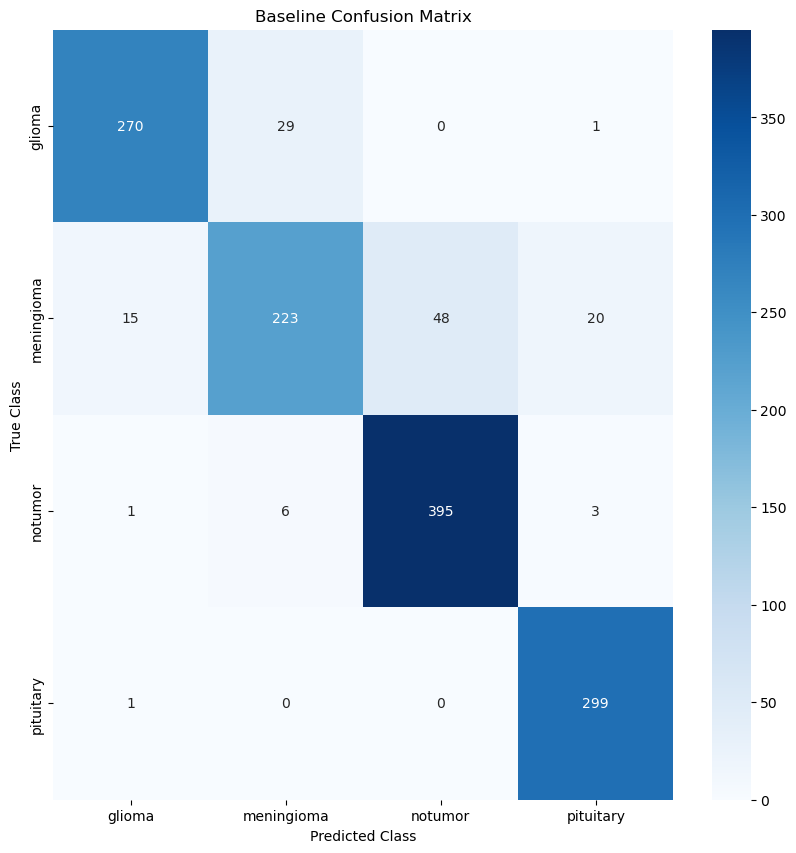

                Accuracy  Precision    Recall  F1 Score
Neural Network  0.905416   0.904306  0.905416  0.902532


In [34]:
# Plot the confusion matrix
m.plot_confusion_matrix(cm, class_paths, 'Baseline')

# Display the metrics DataFrame
print(metrics_df)